In [1]:
import tensorflow as tf

# Initialize TPU
try:
    resolver = tf.distribute.cluster_resolver.TPUClusterResolver()  # Detect TPU
    tf.config.experimental_connect_to_cluster(resolver)
    tf.tpu.experimental.initialize_tpu_system(resolver)
    strategy = tf.distribute.TPUStrategy(resolver)  # Define TPU strategy
    print("All TPU devices: ", tf.config.list_logical_devices('TPU'))
except ValueError:
    raise SystemError('TPU device not found')

print("TPU initialized successfully!")


All TPU devices:  [LogicalDevice(name='/device:TPU:0', device_type='TPU'), LogicalDevice(name='/device:TPU:1', device_type='TPU'), LogicalDevice(name='/device:TPU:2', device_type='TPU'), LogicalDevice(name='/device:TPU:3', device_type='TPU'), LogicalDevice(name='/device:TPU:4', device_type='TPU'), LogicalDevice(name='/device:TPU:5', device_type='TPU'), LogicalDevice(name='/device:TPU:6', device_type='TPU'), LogicalDevice(name='/device:TPU:7', device_type='TPU')]
TPU initialized successfully!


In [13]:
!pip install tensorflow==2.15.*

In [14]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
import shutil
import random

import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

import gdown

In [4]:
file_id = '1Zaxt7yhg18WYpuT8eO94_2__6q6yIdOd'
gdown.download(f'https://drive.google.com/uc?id={file_id}', 'DATASET_CLEAN.zip', quiet=False)

Downloading...
From (original): https://drive.google.com/uc?id=1Zaxt7yhg18WYpuT8eO94_2__6q6yIdOd
From (redirected): https://drive.google.com/uc?id=1Zaxt7yhg18WYpuT8eO94_2__6q6yIdOd&confirm=t&uuid=d490bd84-c5e8-4dfd-9508-0a7322d709a0
To: /content/DATASET_CLEAN.zip
100%|██████████| 123M/123M [00:01<00:00, 108MB/s]


'DATASET_CLEAN.zip'

In [5]:
!unzip DATASET_CLEAN.zip

Streaming output truncated to the last 5000 lines.
  inflating: Capstone/resized/Severe_DR/2577_left._aug_13.jpeg  
  inflating: Capstone/resized/Severe_DR/5823_left._aug_24.jpeg  
  inflating: Capstone/resized/Severe_DR/932_left._aug_25._aug_5._aug_3._aug_26.jpeg  
  inflating: Capstone/resized/Severe_DR/1471_right._aug_5.jpeg  
  inflating: Capstone/resized/Severe_DR/6502_right._aug_13._aug_0.jpeg  
  inflating: Capstone/resized/Severe_DR/687_left._aug_20.jpeg  
  inflating: Capstone/resized/Severe_DR/4366_left._aug_3._aug_23.jpeg  
  inflating: Capstone/resized/Severe_DR/391_right._aug_24._aug_11.jpeg  
  inflating: Capstone/resized/Severe_DR/3868_left._aug_25._aug_22._aug_0._aug_2.jpeg  
  inflating: Capstone/resized/Severe_DR/1162_left._aug_23._aug_27.jpeg  
  inflating: Capstone/resized/Severe_DR/1196_left._aug_26._aug_7._aug_24.jpeg  
  inflating: Capstone/resized/Severe_DR/1350_right._aug_17.jpeg  
  inflating: Capstone/resized/Severe_DR/1391_left._aug_7._aug_17.jpeg  
  inflat

In [15]:
TRAIN_DIR = '/content/Capstone/resized'
VAL_DIR = '/content/Capstone/resized1'
BATCH_SIZE = 64

In [16]:
#Pra-pemrosesan Data:
TRAIN_DATAGENERATOR = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    fill_mode='nearest')

VALIDATION_DATAGENERATOR = ImageDataGenerator(
    rescale=1./255
)

TRAIN_DATAGENERATOR_FINAL = TRAIN_DATAGENERATOR.flow_from_directory(
    TRAIN_DIR,
    target_size=(224, 224),
    batch_size=BATCH_SIZE,
    shuffle=True,
    class_mode='categorical')

VALIDATION_DATAGENERATOR_FINAL = VALIDATION_DATAGENERATOR.flow_from_directory(
    VAL_DIR,
    target_size=(224, 224),
    batch_size=BATCH_SIZE,
    shuffle=False,
    class_mode='categorical')


Found 7926 images belonging to 9 classes.
Found 900 images belonging to 9 classes.


In [8]:
!pip install tensorflow==2.15.*

In [17]:
from tensorflow.keras import layers, models
from keras.applications import imagenet_utils
from tensorflow.keras.applications import MobileNet
from keras.applications.mobilenet import preprocess_input
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam


In [18]:
TF_model = MobileNet(input_shape=(224,224, 3), weights='imagenet', include_top=False)

17225924/17225924 [==============================] - 0s 0us/step


In [19]:
for layer in TF_model.layers:
    layer.trainable = False

In [20]:
# Tambahkan fully connected layer baru
xi = TF_model.output
xi = GlobalAveragePooling2D()(xi)
xi = Dense(1024, activation='relu')(xi)
output = Dense(9, activation='softmax')(xi)
TF_new_model = Model(inputs=TF_model.input, outputs=output)

In [21]:
TF_new_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizati  (None, 112, 112, 32)      128       
 on)                                                             
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D  (None, 112, 112, 32)      288       
 )                                                               
                                                                 
 conv_dw_1_bn (BatchNormali  (None, 112, 112, 32)      128   

In [22]:
from sklearn.utils.class_weight import compute_class_weight

In [23]:
train_labels = TRAIN_DATAGENERATOR_FINAL.classes
class_indices = TRAIN_DATAGENERATOR_FINAL.class_indices
class_names = list(class_indices.keys())


In [24]:
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_labels),
    y=train_labels
)

class_weights_dict = dict(enumerate(class_weights))
print("Class Weights:", class_weights_dict)

Class Weights: {0: 0.9785185185185186, 1: 0.9785185185185186, 2: 1.1008333333333333, 3: 0.9785185185185186, 4: 0.9785185185185186, 5: 0.9785185185185186, 6: 0.9785185185185186, 7: 0.9785185185185186, 8: 1.066182405165456}


In [25]:
TF_new_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [26]:
EPOCHS = 80

history = TF_new_model.fit(
    TRAIN_DATAGENERATOR_FINAL,
    epochs=EPOCHS,
    validation_data= VALIDATION_DATAGENERATOR_FINAL,
    class_weight=class_weights_dict,
    verbose=1,
)

Epoch 1/80
124/124 [==============================] - 103s 814ms/step - loss: 1.0199 - accuracy: 0.5925 - val_loss: 0.7746 - val_accuracy: 0.6622
Epoch 2/80
124/124 [==============================] - 99s 798ms/step - loss: 0.7246 - accuracy: 0.6889 - val_loss: 0.6345 - val_accuracy: 0.7311
Epoch 3/80
124/124 [==============================] - 99s 799ms/step - loss: 0.6253 - accuracy: 0.7422 - val_loss: 0.5980 - val_accuracy: 0.7556
Epoch 4/80
124/124 [==============================] - 95s 763ms/step - loss: 0.5783 - accuracy: 0.7507 - val_loss: 0.5571 - val_accuracy: 0.7667
Epoch 5/80
124/124 [==============================] - 100s 803ms/step - loss: 0.5373 - accuracy: 0.7763 - val_loss: 0.5365 - val_accuracy: 0.7722
Epoch 6/80
124/124 [==============================] - 99s 801ms/step - loss: 0.5079 - accuracy: 0.7845 - val_loss: 0.5118 - val_accuracy: 0.7900
Epoch 7/80
124/124 [==============================] - 99s 801ms/step - loss: 0.4688 - accuracy: 0.8048 - val_loss: 0.4122 - val_

In [27]:
val_labels = VALIDATION_DATAGENERATOR_FINAL.classes

y_pred = TF_new_model.predict(VALIDATION_DATAGENERATOR_FINAL)
x_pred = np.argmax(y_pred, axis=1)

class_names = list(VALIDATION_DATAGENERATOR_FINAL.class_indices.keys())
print("Classification Report:\n")
print(classification_report(val_labels, x_pred, target_names=class_names))

15/15 [==============================] - 5s 314ms/step
Classification Report:

                precision    recall  f1-score   support

      Immature       1.00      1.00      1.00       100
    MataNormal       0.96      1.00      0.98       100
        Mature       1.00      1.00      1.00       100
       Mild_DR       0.98      0.98      0.98       100
   Moderate_DR       0.90      0.99      0.94       100
     Normal_DR       0.98      0.96      0.97       100
Proliferate_DR       0.99      0.98      0.98       100
     Severe_DR       1.00      0.93      0.96       100
  infected_eye       1.00      0.96      0.98       100

      accuracy                           0.98       900
     macro avg       0.98      0.98      0.98       900
  weighted avg       0.98      0.98      0.98       900



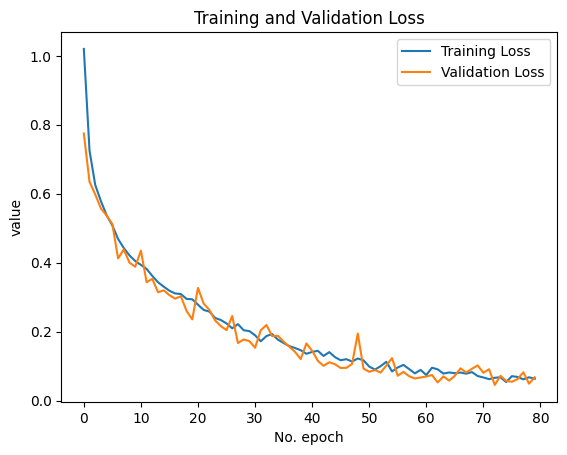

In [28]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.ylabel('value')
plt.xlabel('No. epoch')
plt.legend(loc="upper right")
plt.show()

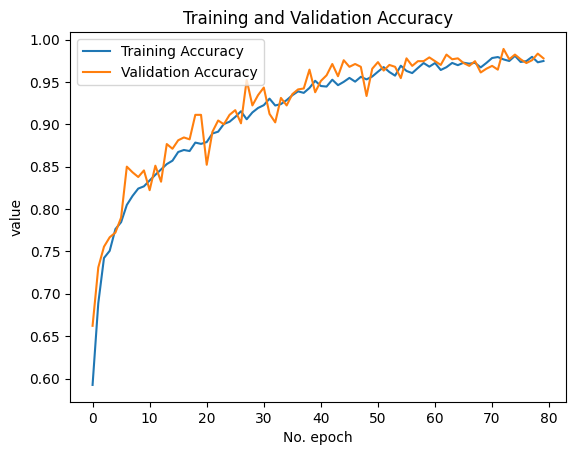

In [29]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.ylabel('value')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

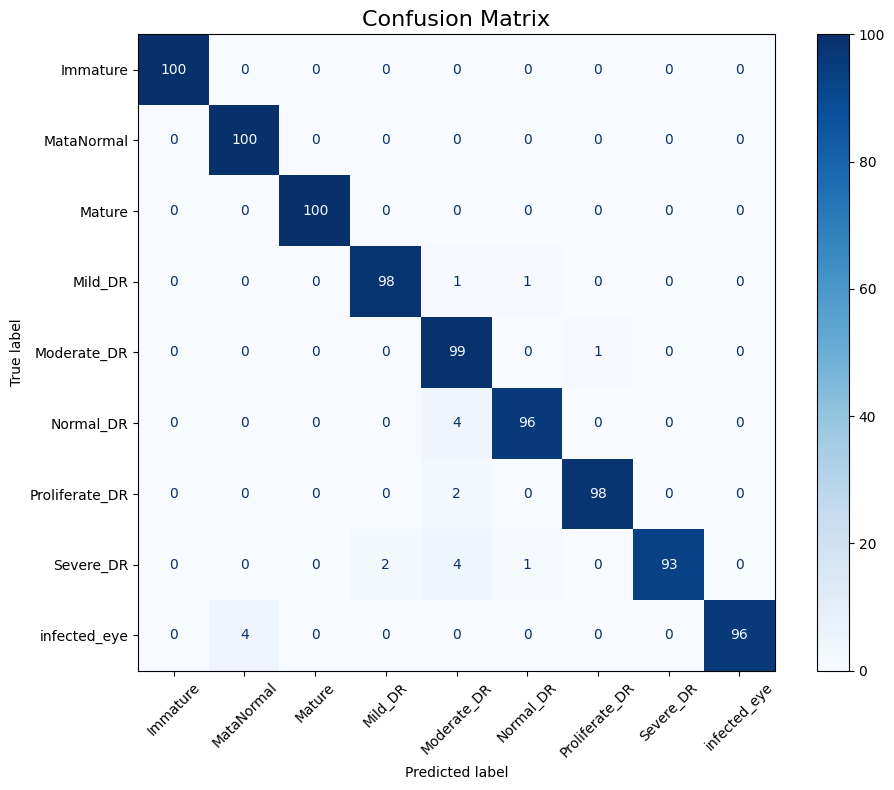

In [71]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(val_labels, x_pred)

fig, ax = plt.subplots(figsize=(10, 8))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues, ax=ax, xticks_rotation=45)
ax.set_title("Confusion Matrix", fontsize=16)

plt.tight_layout()
plt.show()

In [31]:
from google.colab import files
from keras.preprocessing import image

In [32]:
print(TRAIN_DATAGENERATOR_FINAL.class_indices)

{'Immature': 0, 'MataNormal': 1, 'Mature': 2, 'Mild_DR': 3, 'Moderate_DR': 4, 'Normal_DR': 5, 'Proliferate_DR': 6, 'Severe_DR': 7, 'infected_eye': 8}


Saving 4058_left.jpeg to 4058_left.jpeg


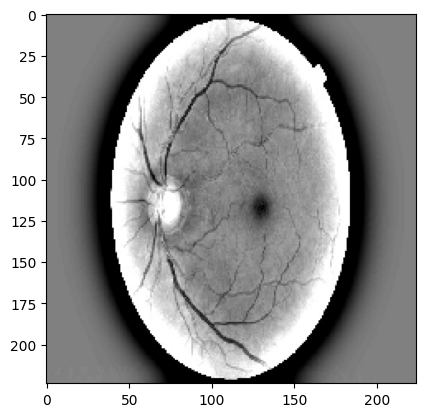

In [76]:
uploaded = files.upload()

for fn in uploaded.keys():
    path = fn
    img = keras.utils.load_img(path, target_size=(224, 224))
    img_array = keras.utils.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    gambar = keras.applications.mobilenet.preprocess_input(img_array)
    imgplot = plt.imshow(img)
    plt.show()

In [77]:
predictions = TF_new_model.predict(gambar)
hasil = np.argmax(predictions)

if hasil == 0:
  print("Katarak: Dengan Tingkat Immature")
elif hasil == 1:
  print("Mata Anda Sehat, Tidak Mengalami Katarak, dan Ifeksi Mata Kering")
elif hasil == 2:
  print("Katarak: Dengan Tingkat Mature")
elif hasil == 3:
  print("Diabetic Retinopathy: Dengan Tingkat Mild")
elif hasil == 4:
  print("Diabetic Retinopathy: Dengan Tingkat Moderate")
elif hasil == 5:
  print("Diabetic Retinopathy: Dengan Tingkat Normal")
elif hasil == 6:
  print("Diabetic Retinopathy: Dengan Tingkat Proliferate")
elif hasil == 7:
  print("Diabetic Retinopathy: Dengan Tingkat Severe")
elif hasil == 8:
  print("Ifeksi Mata kering")
else:
  print("Invalid")

#{'Immature': 0, 'MataNormal': 1, 'Mature': 2, 'Mild_DR': 3, 'Moderate_DR': 4, 'Normal_DR': 5, 'Proliferate_DR': 6, 'Severe_DR': 7, 'infected_eye': 8}

1/1 [==============================] - 0s 47ms/step
Diabetic Retinopathy: Dengan Tingkat Normal


In [35]:
TF_new_model.save('MATANE_MODEL_FINAL.h5')
tf.keras.models.save_model(TF_new_model, 'MATANE_MODEL_FINA.hdf5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
<ipython-input-35-f20b2079650c>:2: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(TF_new_model, 'MATANE_MODEL_FINA.hdf5')


In [55]:
converter = tf.lite.TFLiteConverter.from_keras_model(TF_new_model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model = converter.convert()
with open('MATANE_MODEL_FINAL.tflite', 'wb') as f:
  f.write(tflite_model)